# RGI-07: Region 12 (Caucasus and Middle East)

F. Maussion & S. Galos, June 2021

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import numpy as np
from utils import mkdir

## Files and storage paths

In [2]:
# Region of interest 
reg = 12

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files # we are comparing it later to GRI7a files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
# rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '12_rgi60_CaucasusMiddleEast.zip')

In [3]:
# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')
box_file = os.path.join(support_dir, 'RGI07_R12_UCA.tar.gz')

### Load the input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
toprint = []
for subid in shp.subm_id.unique():
    s_loc = shp.loc[shp.subm_id == subid]
    s = ''
    for c in ['subm_id', 'analysts', 'src_date']:
        toprint = s_loc[c].unique()
        if c != 'src_date':
            s += ' ' + (str(toprint[0]))
        else:
            for d in toprint:
                s += ' ' + d[:4]
    print(s)

 76.0 Nosenko, Gennadi (Gennady) 2004
 79.0 Nosenko, Gennadi (Gennady) 2004
 81.0 Nosenko, Gennadi (Gennady) 2004
 83.0 Nosenko, Gennadi (Gennady) 2004
 87.0 Nosenko, Gennadi (Gennady) 2004
 327.0 Khromova, Tatyana 2001
 341.0 Seliverstov, Yriy 2000
 423.0 Nosenko, Gennadi (Gennady) 2004
 424.0 Nosenko, Gennadi (Gennady) 1999
 425.0 Khromova, Tatyana 1999
 426.0 Nosenko, Gennadi (Gennady) 1999
 427.0 Nosenko, Gennadi (Gennady) 2001
 428.0 Nosenko, Gennadi (Gennady) 2004
 429.0 Nosenko, Gennadi (Gennady) 2004
 588.0 Ashkan, Farokhnia; Karimi, Neamat; Sara, Sheshangosht 2011
 642.0 Tielidze, Levan 2014 2013 2014 2014 2011 2016
 643.0 Tielidze, Levan 1987 1985 1986 1986 1986 1987
 644.0 Tielidze, Levan 1960
 662.0 Sarikaya, Mehmet Akif 2008 2006 2006 2004 2008 2009 2011
 724.0 Tielidze, Levan 1999 2000 2000 2000 1999 2002


### Apply selection criteria to create the RGI7 data subset

In [6]:
# try to get the data relevant for RGI07 and select by attributes - 
# for Caucasus we use 'subm_id' 642 by analyst 'Tielidze, Levan' which corresponds to the most recent (ca. 2013)
# of three available data sets for Caucasus by this anayst (others are from around 1960 and appr. 1985 respectively)
RGI_ss_caucasus = shp.loc[shp['subm_id'] == 724]
len(RGI_ss_caucasus)

2185

In [7]:
# try to get the data relevant for RGI07 and select by attributes - for Middle East: 'subm_id' 588 ()
RGI_ss_middle_east = shp.loc[shp['subm_id'] == 588]
len(RGI_ss_middle_east)

484

In [8]:
RGI_ss_middle_east.iloc[0]

line_type                                            glac_bound
anlys_id                                               297051.0
glac_id                                          G049337E33320N
anlys_time                                  2014-07-05T00:00:00
area                                                4651.577985
db_area                                                0.004652
width                                                       0.0
length                                                      0.0
primeclass                                                  0.0
min_elev                                                    0.0
mean_elev                                                   0.0
max_elev                                                    0.0
src_date                                    2011-09-01T00:00:00
rec_status                                                 okay
glac_name                                                  None
wgms_id                                 

In [9]:
# combine the two geodataframes
RGI_ss = RGI_ss_caucasus.append(RGI_ss_middle_east)

### Should we add some 1985 glaciers for completeness?

Hugonnet et al made a subjective choice to add some 1985 glaciers... should we as well?

In [10]:
# We decided not to for now
# EG:
# RGI_ss_caucasus_1985 = shp.loc[shp['subm_id'] == 644]
# len(RGI_ss_caucasus_1985)

### Should we add missing glaciers (only a few in peripheral areas) based on RGI06?

This is done based on a manually created shapefile mask containing the few glacierized areas not considered in the above data. Note that many of the glaciers added by this procedure are not glaciers by common definition but rock glaciers or even areas without ice in reality. Apart from that, outlines partly suffer from incorrect spatial positioning etc...  

In [11]:
# load a shapefile containing polygons which define areas uncovered by newly created RGI07 file
UCA = gpd.read_file('tar://' + box_file + '/RGI07_R12_UCA/RGI07_R12_UCA.shp')

In [12]:
# extract glacier outlines for regions mentioned above from glims data
df_UCA = gpd.overlay(shp, UCA, how='intersection')

In [13]:
# select submission ID of interesst (for RGI07 only subm_ID 662 available)
df_UCA = df_UCA.loc[df_UCA['subm_id']== 662]

In [14]:
# append df_UCA to RGI_ss
RGI_ss = RGI_ss.append(df_UCA, sort = False);

## Write out and tar 

In [15]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
RGI_ss.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI12/
RGI12/RGI12.cpg
RGI12/RGI12.dbf
RGI12/RGI12.prj
RGI12/RGI12.shp
RGI12/RGI12.shx
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI12.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI12'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [16]:
# Just to know the name of the file to open from zip
#import zipfile
#with zipfile.ZipFile(rgi6_reg_file, "r") as z:
#    for f in z.filelist:
#        if '.shp' in f.filename:
#            fname = f.filename

# load reference data 
#ref_odf = gpd.read_file('zip://' + rgi6_reg_file + '/' + fname)



In [17]:
# now the reference data to be compared with is GLIMS (l2 files)
ref_odf = gpd.read_file(l2_dir + '/' + 'RGI12')
type(ref_odf)

geopandas.geodataframe.GeoDataFrame

## Compare new RGI-file and reference data set 

### Number of elements (differences do not necessarily depict major problems)

In [18]:
print('Number of glaciers in new RGI subset:', len(RGI_ss))
print('Number of glaciers in reference data:', len(ref_odf))
print('Difference:', len(RGI_ss)-len(ref_odf))

Number of glaciers in new RGI subset: 2720
Number of glaciers in reference data: 10599
Difference: -7879


In [19]:
print('GLIMS:| Min id:', ref_odf['anlys_id'].min(), '|Max id:', ref_odf['anlys_id'].max())

GLIMS:| Min id: 1504.0 |Max id: 720332.0


In [33]:
print('RGI7a:| Min id:',RGI_ss['anlys_id'].min(), '|Max id:',RGI_ss['anlys_id'].max())
print()

RGI7a:| Min id: 297051.0 |Max id: 720332.0



The interior GLIMS polygons have the same glacierID as the exterior one, so for every glacier there are several polygons with the same glacierID.
If both datasets agree, the number of glacier IDs should be the same: **but it is not**

In [21]:
# see how many glaciers are there (unique glacierIDs)
print('GLIMS:',len(ref_odf['glac_id'].unique()))
# see how many glaciers are there (unique glacierIDs)
print('RGI7a:',len(RGI_ss['glac_id'].unique()))

GLIMS: 4231
RGI7a: 2720


In [22]:
# duplicated glaciers? 
print(ref_odf['glac_id'].duplicated().sum())
#--> 6368 glaciers are duplicated. total_glaciers - unique_glaciers = duplicated_glaciers; 10599-4231 = 6368 --> ok, because the interior polygons count as glacier with same id.

# duplicated glaciers? 
print(RGI_ss['glac_id'].duplicated().sum())
#--> 5 glaciers are duplicated 2556-2551 = 5. --> not ok, 5 glacier duplicated.

6368
0


We see now what are the glaciers that are duplicated:

In [23]:
print("Duplicated glaciers ID in RGI7a are:")
RGI_ss['glac_id'].loc[RGI_ss['glac_id'].duplicated()]

Duplicated glaciers ID in RGI7a are:


Series([], Name: glac_id, dtype: object)

In [24]:
#ref_odf[ref_odf['glac_id'].duplicated()]
#RGI_ss['glac_id'].duplicated()

Show more details about the dupplicated glaciers:

In [25]:
#print(ref_#odf["glac_id"])
dup = RGI_ss.loc[RGI_ss['glac_id'].duplicated()]

#location of the duplicated element(s) and their original element:
ind = RGI_ss[['glac_id', 'src_date']].loc[RGI_ss['glac_id'].duplicated()].index
#print(RGI_ss.loc[RGI_ss['glac_id'].duplicated()])
dup = RGI_ss["glac_id"][RGI_ss['glac_id'].duplicated()]
dup_a = dup.values

dup_l = dup_a.tolist()

a=RGI_ss.loc[RGI_ss['glac_id'].isin(dup_l)]
a["src_date"]
#RGI_ss['glac_id'].isin([dup.values])
#print(ind)
#RGI_ss.loc[RGI_ss['glac_id'][ind]]

#RGI_ss[RGI_ss["glac_id"] == ind[1]]
#ind[1]
#print(RGI_ss['glac_id'][ind-1])
#type(RGI_ss['glac_id'][ind-1])

#od = pd.concat([RGI_ss['glac_id'][ind], RGI_ss['glac_id'][ind-1]], axis=0)
#dupdup = od.sort_index(axis=0)
#np.array(dupdup)

#RGI_ss['glac_id'].duplicated()
#RGI_ss[dupdup[1:3]]
#dupdup.index
#a = pd.concat([RGI_ss['glac_id'][ind], RGI_ss['glac_id'][ind-1]])
#RGI_ss['glac_id'].loc[RGI_ss['glac_id'][a]]
#type(RGI_ss['glac_id'][ind])
#print(RGI_ss['glac_id'][ind-1])

#RGI_ss[(ind-1):ind]
#type(list(range(1,4)))
#RGI_ss[]

Series([], Name: src_date, dtype: object)

In [26]:
ref_odf.sort_values(by = "glac_id")["glac_id"]

8363    G035444E38534N
8364    G039118E39476N
8365    G039124E39475N
8366    G039136E39495N
8367    G039288E39456N
             ...      
1777    G052136E35970N
1565    G052226E35769N
1669    G052227E35770N
1391    G052227E35772N
1769    G052236E35770N
Name: glac_id, Length: 10599, dtype: object

In [27]:
10599-8364

2235

### How many nominal glaciers were there in RGI06-R12?

In [28]:
#len(ref_odf.loc[ref_odf.Status == 2])

### Total area

In [29]:
# add an area field to RGI_ss and reference data
RGI_ss['area'] = RGI_ss.to_crs({'proj':'cea'}).area
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [30]:
# print and compare area values
Area_RGI = RGI_ss['area'].sum() * 1e-6
print('Area RGI7a [km²]:', np.round(Area_RGI))
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area Ref (GLIMS) [km²]:', np.round(Area_ref))
d = np.round((Area_RGI - Area_ref))
print('Area difference [km²]:', d, '\nArea difference:', np.round(abs((Area_RGI-Area_ref)/Area_ref*100)),'%')

Area RGI7a [km²]: 1433.0
Area Ref (GLIMS) [km²]: 6885.0
Area difference [km²]: -5452.0 
Area difference: 79.0 %


This difference is due to the fact that the interior polygons in GLIMS count as positive area, not as a "hole" inside the outer polygon.
I don't know how to distinguish the inner/outer polygons in GLIMs `l2_*` files as the line_type attribute is unique. Here an example: 

In [31]:
G041335E43260N = ref_odf.loc[ref_odf['glac_id'] == 'G041335E43260N']
G041335E43260N



,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,CenLon,CenLat,geometry
2008,glac_bound,509372.0,G041335E43260N,2017-08-01T00:00:00,23342.251384,0.023342,0.0,0.0,0.0,0.0,...,Ivane Javakhishvili Tbilisi State University,50,50,80,80,"Tielidze, Levan","Tielidze, Levan",41.335438,43.259960,"POLYGON Z ((41.33609 43.26000 0.00000, 41.3361..."
4027,glac_bound,511386.0,G041335E43260N,2017-08-01T00:00:00,40762.594635,0.040763,0.0,0.0,0.0,0.0,...,Ivane Javakhishvili Tbilisi State University,50,50,80,80,"Tielidze, Levan","Tielidze, Levan",41.335504,43.260042,"POLYGON Z ((41.33671 43.25966 0.00000, 41.3368..."
6220,glac_bound,513576.0,G041335E43260N,2017-08-01T00:00:00,16721.943418,0.016722,0.0,0.0,0.0,0.0,...,Ivane Javakhishvili Tbilisi State University,50,50,80,80,"Tielidze, Levan","Tielidze, Levan",41.335158,43.260519,"POLYGON Z ((41.33576 43.26089 0.00000, 41.3360..."
8659,glac_bound,718393.0,G041335E43260N,2020-12-01T00:00:00,33238.524283,0.033238,0.0,0.0,0.0,0.0,...,Ivane Javakhishvili Tbilisi State University,50,50,80,80,"Tielidze, Levan","Tielidze, Levan",41.335461,43.260007,"POLYGON Z ((41.33428 43.26059 0.00000, 41.3342..."


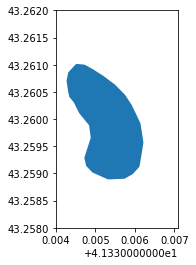

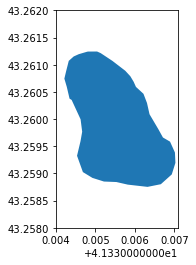

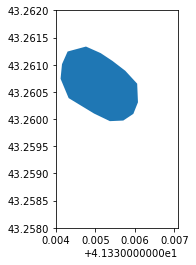

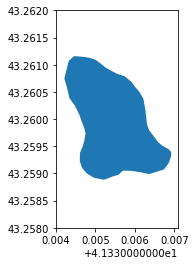

In [32]:
for i in range(len(G041335E43260N)):
    pl = G041335E43260N.iloc[[i]].plot()
#pl.set_xlim([43.3, ])
    pl.set_ylim([43.258, 43.262])
    pl.set_xlim([41.334, 41.3371])

# End of revised noteboook